# Neutrino Trident Production

This notebook loads and tests the MC events for neutrino trident production off nuclei and protons,

$$\nu_\alpha \,+\, N \,\to\, \nu_\beta \,+\, \ell^+_{\kappa} \,+\, \ell^-_{\gamma} \,+\, N.$$

In this version, we only import MC events for Oxygen and protons with neutrino energies between 0.1 to 10 GeV. This notebook can be easily adapted to import other regimes and targets. Note that only the four-momenta of the final state charged leptons is provided, together with the neutrino energy $E_\nu$ and the momentum transfer to the nuclear targer $Q^2$.

This work is directly based on $\textit{arXiv:1807.10973}$.

## Init

In [1]:
%matplotlib inline

# standard
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.lines as mlines
from matplotlib.pyplot import *
import sys
import scipy.ndimage as ndimage
import os
from scipy.interpolate import interp1d

# custom modules
import fourvec as vec
import const

# Class with all the relevant quantities of a given trident channel/mode
class MC:
    ##############################################    
    # Import datafile and set lepton masses
    def __init__(self, samplesfile, mplus, mminus, Enu_range):
        # array with all data 
        # Enu Q^2 P+(0) P+(1) P+(2) P+(3) P-(0) P-(1) P-(2) P-(3) weight
        self.a  = np.array(np.genfromtxt(samplesfile, dtype=np.float64))
                
        # Only events within energy range
        self.Enu_min = Enu_range[0]
        self.Enu_max = Enu_range[1]
        self.mask= [(self.a[:,0]>self.Enu_min)&(self.a[:,0]<self.Enu_max)]
        self.a = self.a[self.mask]
        
        # charge lepton masses 
        self.mp = mplus
        self.mm = mminus

        # relevant quantities
        self.Enu = self.a[:,0] 
        self.Q2  = self.a[:,1] 
        self.w   = self.a[:,-1]
        self.Pplus = self.a[:,2:6].T 
        self.Pminus = self.a[:,6:10].T
        
        print "Samples imported: ", np.size(self.w)


    ##############################################
    # Function to reweight the neutrino flux
    # the new flux file has to have the GLoBES format of 7 columns:
    #
    # Enu(GeV) nue numu nutau nue_bar numu_bar nutau_bar
    #
    # The uniform flux is used in the MC is set to 1, so user can choose the units of the new weights
    def Reweight(self, new_flux_file, flavour):
        M = np.loadtxt(new_flux_file, dtype=np.float64)
        en = M[:,0]
        f  = M[:,flavour]
        # interpolate numu flux and fill out of range values w/ 0
        flux = interp1d(en, f, fill_value=0, bounds_error=False)
        
        self.new_w = self.w * flux(self.Enu)

    ##############################################    
    # flux convolved cross section calculated from the samples in 1e-48cm^2*arbitrary_flux_units (using uniform flux)
    def total_fxs(self):
        return np.sum(self.w)
    
    # flux convolved cross section calculated from the samples in 1e-48cm^2*arbitrary_flux_units (using new flux)
    def total_fxs_new_flux(self):
        return np.sum(self.new_w)
    ##############################################    
    
    
    ##############################################    
    # invariant mass of the two charged leptons 
    def invmassSQR(self):
        return vec.dot4(self.Pplus+self.Pminus, self.Pplus+self.Pminus)

    # separation angle of the two charged leptons in rads 
    def sepangle(self):
        return np.arccos(vec.dot3(self.Pplus, self.Pminus)/np.sqrt(vec.dot3(self.Pplus, self.Pplus)*vec.dot3(self.Pminus, self.Pminus)))

    # angle of wrt to the beam of negatively charged lepton in rads 
    def minus_beam(self):
        return np.arccos(self.Pminus[3,:]/np.sqrt(vec.dot3(self.Pminus, self.Pminus)))
    
    # angle of wrt to the beam of positively charged lepton in rads 
    def plus_beam(self):
        return np.arccos(self.Pplus[3,:]/np.sqrt(vec.dot3(self.Pplus, self.Pplus)))

    # Energy of negatively charged lepton in GeV
    def Eminus(self):
        return self.Pminus[0,:]

    # Energy of positively charged lepton in GeV
    def Eplus(self):
        return self.Pplus[0,:]


## Import data for $^{16}$O and $p^+$

In this example I will import the MC events for Argon and protons (with and without Pauli blocking).
Note the usual shorthand for trident channels:

$$abcd \equiv \nu_a \,\to\, \nu_b \,+\, \ell_c^+ \,+\, \ell_d^-$$


In [2]:
#########################################
# Neutrinos

# Coherent for 40Ar
mm_Ocoh = MC("../events/MC_events_numu_to_numu_mu+_mu-_coh_8_16_0_10.dat", const.Mmu, const.Mmu, (0.1,10.))
mm_Ccoh = MC("../events/MC_events_numu_to_numu_mu+_mu-_coh_6_12_0_10.dat", const.Mmu, const.Mmu, (0.1,10.))
mm_Pbcoh = MC("../events/MC_events_numu_to_numu_mu+_mu-_coh_82_207_0_10.dat", const.Mmu, const.Mmu, (0.1,10.))
# Elatic proton -- Pauli blocking ON
mm_dif_PB = MC("../events/MC_events_numu_to_numu_mu+_mu-_proton_PB_0_10.dat", const.Mmu, const.Mmu, (0.1,10.))

Samples imported:  405154
Samples imported:  405080
Samples imported:  401540
Samples imported:  404895


# Roughly what the number of events is in the DUNE ND

In [57]:
# values for events/POT/year/ton
# Navogrado * 1e6 grams / mproton (g/mol) * xsec_units * (POT/year) / 0.05GeV

norm = 6.022*1e23 *1e6*1e-48/0.05

print "mmmm coh 16O Events/1e21POT = ", mm_Ocoh.total_fxs()*norm/16.0
print "mmmm coh 12C Events/1e21POT = ", mm_Ccoh.total_fxs()*norm/12.0
print "mmmm coh 207Pb Events/1e21POT = ", mm_Pbcoh.total_fxs()*norm/207.0
print "mmmm dif Pblocked Events/1e21POT = ", mm_dif_PB.total_fxs()*norm*8

mmmm coh 16O Events/1e21POT =  0.0131575591907
mmmm coh 12C Events/1e21POT =  0.0108850358073
mmmm coh 207Pb Events/1e21POT =  0.0276442923903
mmmm dif Pblocked Events/1e21POT =  0.140203433168


# Trident event distribution in $E_\nu$

NameError: name 'ax3' is not defined

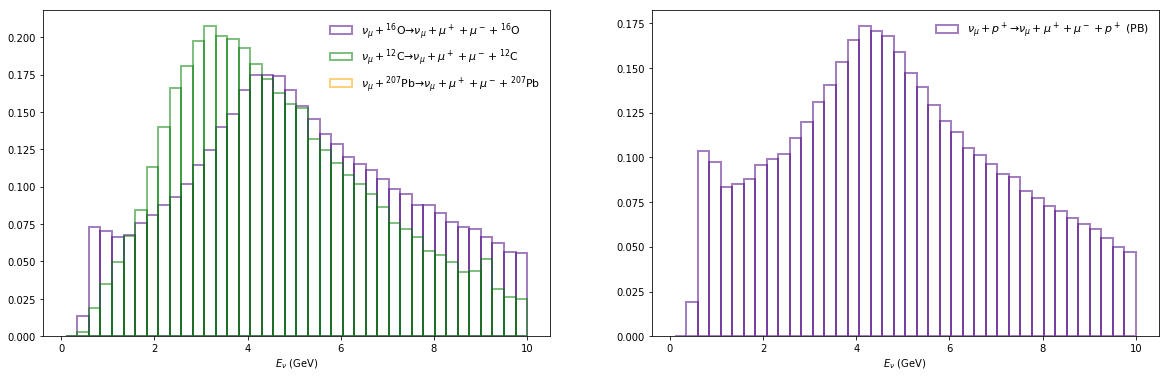

In [3]:
# plot the distribution in neutrino energy as a sanity check
def plot_nuflux(ax, colour, MC, title):

    
    # defs
    kwargs = {"facecolor" : "None", 
              "edgecolor" : colour,
              "lw"        : 2.0,
              "alpha"     : 0.5,
              "weights" : MC.w,
              "bins" : 40,
              "density" : True,
              "label" : title} 
    
    # hists
    h = ax.hist(MC.Enu, range=(0.1,MC.Enu_max), **kwargs)
    ax.set_xlabel(r"$E_\nu$ (GeV)")

fig,  axes = plt.subplots(nrows=1, ncols=2,figsize = (20,6))
(ax1, ax2)= axes


plot_nuflux(ax1,"indigo", mm_Ocoh, 
           r"$\nu_\mu + ^{16}$O$ \to \nu_\mu + \mu^+ + \mu^- + ^{16}$O")
plot_nuflux(ax1,"green", mm_Ccoh, 
           r"$\nu_\mu + ^{12}$C$ \to \nu_\mu + \mu^+ + \mu^- + ^{12}$C")
plot_nuflux(ax1,"orange", mm_Pbcoh, 
           r"$\nu_\mu + ^{207}$Pb$ \to \nu_\mu + \mu^+ + \mu^- + ^{207}$Pb")

plot_nuflux(ax2,"indigo", mm_dif_PB, 
           r"$\nu_\mu + p^+ \to \nu_\mu + \mu^+ + \mu^- + p^+$ (PB)")


ax1.legend(loc="upper right", frameon=False, fontsize=11)
ax2.legend(loc="upper right", frameon=False, fontsize=11)
ax3.legend(loc="upper right", frameon=False, fontsize=11)

## Plotting physical observables with the reweighted samples

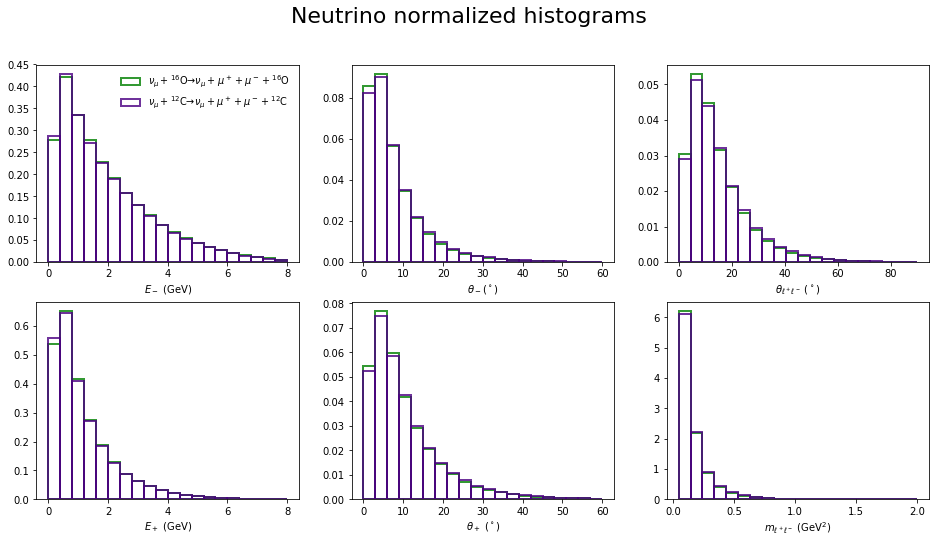

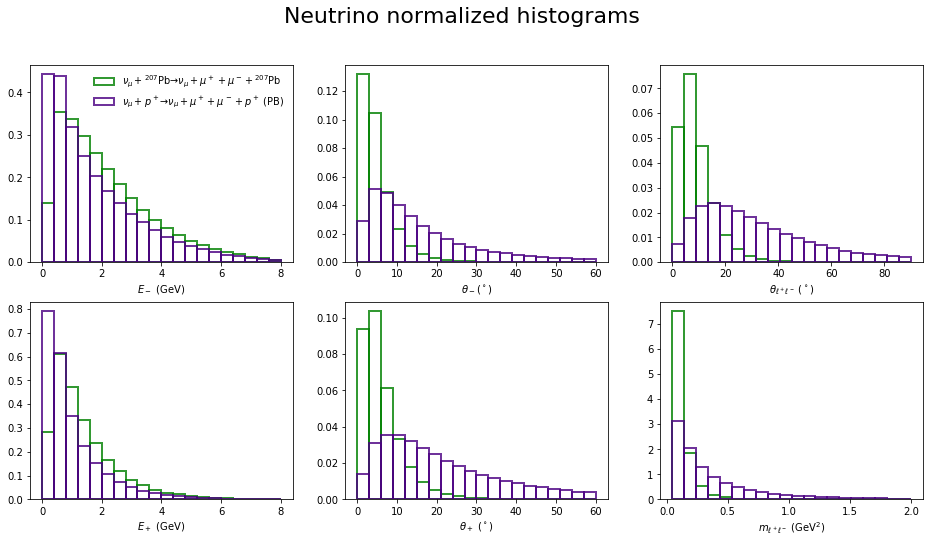

In [68]:
fsize = 14
rad_to_deg = 180.0/np.pi

# figs
fig1,  axes1 = plt.subplots(nrows=2, ncols=3,figsize = (16,8))
fig2,  axes2 = plt.subplots(nrows=2, ncols=3,figsize = (16,8))

def plot_dists(MC, colour, title, axes):

    ((ax1, ax2, ax3), (ax4, ax5, ax6)) = axes


    # defs
    kwargs = {"facecolor" : "None", 
              "edgecolor" : colour,
              "lw"        : 2.0,
              "alpha"     : 0.8,
              "weights" : MC.w,
              "bins" : 20,
              "density" : True,
              "label"  : title} 
    
    # hists
    h = ax1.hist(MC.Eminus(), range=(0,MC.Enu_max*0.8), **kwargs)
    ax1.set_xlabel(r"$E_-$ (GeV)")

    h = ax2.hist(MC.minus_beam()*rad_to_deg, range=(0,60), **kwargs)
    ax2.set_xlabel(r"$\theta_-(^\circ$)")

    h = ax3.hist(MC.sepangle()*rad_to_deg, range=(0,90), **kwargs)
    ax3.set_xlabel(r"$\theta_{\ell^+ \ell^-}$ ($^\circ$)")
    
    h = ax4.hist(MC.Eplus(), range=(0,MC.Enu_max*0.8), **kwargs)
    ax4.set_xlabel(r"$E_+$ (GeV)")

    h = ax5.hist(MC.plus_beam()*rad_to_deg, range=(0,60), **kwargs)
    ax5.set_xlabel(r"$\theta_+$ ($^\circ$)")

    h = ax6.hist(MC.invmassSQR(), range=((MC.mm+MC.mp)**2,2.0), **kwargs)    
    ax6.set_xlabel(r"$m_{\ell^+\ell^-}$ (GeV$^2$)")
    

########################################
# neutrino
fig1.suptitle("Neutrino normalized histograms", fontsize=22)
plot_dists(mm_Ocoh,'green', 
           r"$\nu_\mu + ^{16}$O$ \to \nu_\mu + \mu^+ + \mu^- + ^{16}$O", axes1)
plot_dists(mm_Pbcoh,'green', 
           r"$\nu_\mu + ^{207}$Pb$ \to \nu_\mu + \mu^+ + \mu^- + ^{207}$Pb", axes2)
axes1[0,0].legend(loc='upper right', frameon=False, fontsize=0.7*fsize)

fig2.suptitle("Neutrino normalized histograms", fontsize=22)


plot_dists(mm_Ccoh,'indigo', 
           r"$\nu_\mu + ^{12}$C$ \to \nu_\mu + \mu^+ + \mu^- + ^{12}$C", axes1)
plot_dists(mm_dif_PB,'indigo', 
           r"$\nu_\mu + p^+ \to \nu_\mu + \mu^+ + \mu^- + p^+$ (PB)", axes2)
axes2[0,0].legend(loc='upper right', frameon=False, fontsize=0.7*fsize)


## Additional tests

In [ ]:
mm_Ccoh = MC("../events/MC_events_numu_to_numu_mu+_mu-_coh_6_12_0_10.dat", const.Mmu, const.Mmu, (0.1,10.))
HEPmm_Ccoh = MC_HEPevt("../HEPevt/MC_events_numu_to_numu_mu+_mu-_coh_6_12_0_10.dat", const.Mmu, const.Mmu, (0.1,10.))


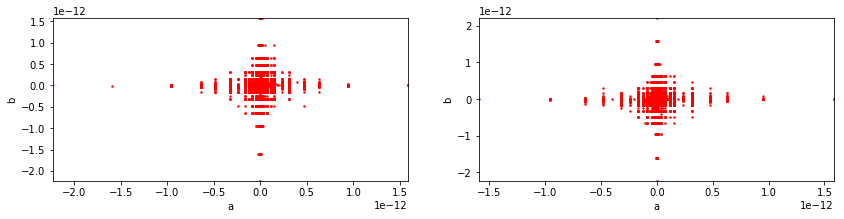

In [35]:
# Test the different kinematical limits

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = (14,3))

# charged lepton masses are recovered
def check_masses(MC, ax):
    # charged lepton masses are recovered
    mplus  = np.sqrt(vec.dot4(MC.Pplus, MC.Pplus))
    mminus = np.sqrt(vec.dot4(MC.Pminus, MC.Pminus))
    
    a = mplus/MC.mp - 1.
    b = mminus/MC.mm - 1.
#     a = MC.mp
#     b = MC.mm

    ax.set_xlim(np.min(a), np.max(a)), ax.set_ylim(np.min(b), np.max(b))
    ax.set_xlabel('a'), ax.set_ylabel('b')
    ax.scatter(a,b, lw=0, s=6,c="r")

    
check_masses(mm_coh, ax1)
check_masses(mm_dif_PB, ax2)
